<a href="https://colab.research.google.com/github/Yvonneamg/Modelling-the-epidemiologic-evolution-of-Diabetes-Mellitus-Integrating-Physiological-Agent-models/blob/main/Copy_of_WorkingcopyDeGaetanoWork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1: Load the required libraries

In [ ]:
# load the required libraries
!pip install jax jaxlib diffrax numpyro pyreadstat scipy matplotlib pandas
import scipy
import jax # For high performance numerical computing and automatic differentiation
import jax.numpy as jnp
import time
from jax import random
import jax.random as random
from scipy import optimize
!pip install pyreadstat  # For .XPT files
import pandas as pd # For data handling
import numpy as np # For data handling
from jax import jit, vmap
from jax import jit, vmap, random
from jax.experimental.ode import odeint
from scipy.optimize import differential_evolution
import diffrax # For solving ODES
import math
import random
from functools import partial
import matplotlib.pyplot as plt # For visualization
import matplotlib as mpl
import numpyro # For probablistic modeling to be implemented later
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from numpyro.optim import Adam
from numpyro.infer.autoguide import AutoNormal
from numpyro.infer import SVI, Trace_ELBO, init_to_median
print("Setup complete!")

Setup complete!


# Step 2: Renal Glucose elimination model

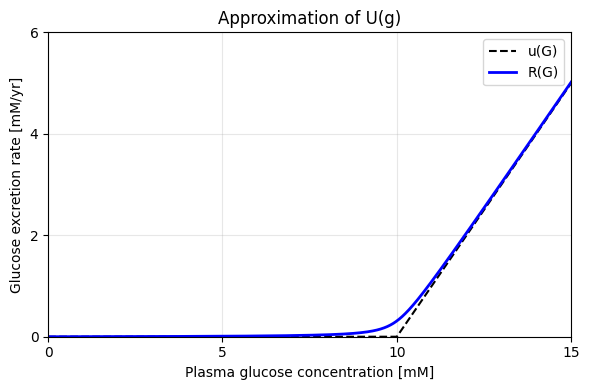

In [ ]:
# The term  𝑅(𝐺(𝑡)) represents the average decrement of glucose concentration due to renal glucose elimination and to possible therapy with SGLT-2 inhibitors.
# Construction of equation 8
s_GR = 1.0  # mM/yr per mM (scale for linear elimination)
rho_GR = 0.01 # mM (smoothing factor)
G_R = 10.0  # mM (renal threshold)

# Glucose range (x-axis: 0 to 15 mM)
G = np.linspace(0, 15, 1000)

# Exact step function u(G) from Eq. (9)
u_G = np.where(G < G_R, 0, (s_GR * (G - G_R)))  # Piecewise: 0 below threshold, linear above

# Smooth approximation R(G) from Eq. (8)
discriminant = (4 * rho_GR * G) + ((G - G_R - rho_GR)**2)
R_G = (s_GR / 2) * (np.sqrt(discriminant) + (G - G_R - rho_GR))

# Plot dashed for u(G), solid blue for R(G)
plt.figure(figsize=(6, 4))
plt.plot(G, u_G, 'k--', linewidth=1.5, label='u(G)')  # Dashed black
plt.plot(G, R_G, 'b-', linewidth=2, label='R(G)')     # Solid blue
plt.xlabel('Plasma glucose concentration [mM]')
plt.ylabel('Glucose excretion rate [mM/yr]')
plt.xlim(0, 15)
plt.ylim(0, 6)
plt.xticks(np.arange(0, 16, 5))  # x-axis ticks: 0, 5, 10, 15
plt.yticks(np.arange(0, 7, 2))   # y-axis ticks: 0, 2, 4, 6
plt.grid(True, alpha=0.3)  # Light grid for readability
plt.legend()
plt.title('Approximation of U(g)')
plt.tight_layout()
plt.savefig("plot1.png", dpi=300, bbox_inches="tight")
plt.show()

# The smooth R(G) effectively approximates the biological renal threshold mechanism (where kidneys excrete excess glucose only above ~10 mM), no elimination in normoglycemia (G<10 mM), linear spillover in hyperglycemia

# Step 3: Define the Parameters from table 1,2 and 3

In [ ]:
# Define Parameters from Tables 2 and 3
# Base parameters (Table 2 defaults; units as per table)
params_base = {
    't0': 0, #(all cases)
    'tend': 50, #(all cases)
    't_delta': 0.1, #(all cases)
    'G0_N': 5.0, #(all cases)
    'B_0': 1000.0, #(all cases)
    'I0_N': 35.0, #(all cases)
    'S0_N': 0.001, #(all cases)
    'L0_N': 0.01, #(all cases)
    'R0': 0.000422144, #(all cases)

    # Glucose dynamics
    'k_max_G': 1.00948,  # mM/yr (maximal rate of liver determined glycemis rise, all cases)
    'G_0': 5.0,  # mM (initial glycemia, all cases)
    # Beta-cell
    'lambda_BA': 0.005,  # /yr (age decay factor for beta replen, from eq2)
    'k_OB_G': 0.005,  # /yr/mM (glucotoxicity rate, varies)
    'k_B': 25.0,  # Mc/yr (beta replen constant, varies)
    'B0_N': 1000.0,  # Mc (normal beta mass, all cases)
    # Insulin
    'k_OI': 0.5,  # /yr (insulin elimination, all cases)
    'gamma_IG': 2.0,  # # (Hill exponent, all cases)
    'G_I50': 20.0,  # mM (half-max glucose for secretion, all cases)
    'k_max_I': 297.5,  # pM/yr (max insulin secretion, all cases)
    'I_0': 35.0,  # pM (initial insulin, all cases)
    # Peripheral sensitivity S
    'k_S': 0.0001,  # /yr/pM (replen rate, varies)
    'k_SY': 1e-09,  # /yr/pM/yr/(kcal/day) (exercise benefit, all cases)
    'k_OS': 0.1,  # /yr (spont decay,varies)
    'k_OSF': 1e-05,  # /yr/(kcal/day) (food decay, varies)
    'k_OSA': 0.0005,  # /yr/yr (age decay,all cases)
    'S_0': 0.001,  # /yr/pM (initial S, all cases)
    # Central sensitivity L
    'k_L': 0.001,  # mM/pM/yr (replen rate, varies)
    'k_LY': 2e-09,  # /mM/pM/yr/(kcal/day) (exercise benefit, all cases)
    'k_OL': 0.1,  # /yr (spont decay, varies)
    'k_OLF': 1e-05,  # /yr/(kcal/day) (food decay, varies)
    'k_OLA': 0.0005,  # /yr/yr (age decay, all cases)
    'L_0': 0.01,  # mM/pM (initial L, all cases)
    # Renal
    's_GR': 0.001,  # mM/yr/mM (scale,all cases)
    'rho_GR': 0.5,  # # (smoothing, all cases)
    'G_R': 10.0,  # mM (threshold, all cases)
    'R0_N': 0.000422144,  # mM/yr/mM (not directly used, all cases)
    # Inputs
    'F': 0.0,  # kcal/day (excess food, varies)
    'Y': 0.0,  # kcal/day (exercise, all cases)
    'A0':18.0  # yr (initial age, all cases)
}

# Case-specific overrides from Table 3 (Black=healthy, Red=severe)
params_cases = {
    'Black': params_base.copy(),
    'Blue': params_base.copy(),
    'Green': params_base.copy(),
    'Red': params_base.copy(),
}

# Apply Table 3 variations (e.g., higher decay rates for worse cases)

params_cases['Black'].update({'k_OB_G': 0.005,'k_OS':0.1,'k_OL':0.1,'k_B': 25.0, 'k_S': 0.0001, 'k_L': 0.001, 'F': 0.0, 'k_OSF': 1e-05, 'k_OLF': 1e-5})
params_cases['Blue'].update({'k_OB_G': 0.001,'k_OS':0.01,'k_OL':0.01,'k_B': 5.0, 'k_S': 1e-05, 'k_L': 0.0001, 'F': 500.0, 'k_OSF': 0.0005, 'k_OLF': 0.0005})
params_cases['Green'].update({'k_OB_G': 0.001,'k_OS':0.01,'k_OL':0.01,'k_B': 5.0, 'k_S': 1e-05, 'k_L': 0.0001, 'F': 500.0, 'k_OSF': 0.0002, 'k_OLF': 0.0002})
params_cases['Red'].update({'k_OB_G': 0.001,'k_OS':0.01,'k_OL':0.01,'k_B': 5.0, 'k_S': 1e-05, 'k_L': 0.0001, 'F': 500.0, 'k_OSF': 0.001, 'k_OLF': 0.001})

# Initial conditions (y0: [G, B, I, S, L, A]; B0=1000 Mc from Table 2)
A0=params_base['A0']
y0_base = jnp.array([params_base['G_0'], params_base['B_0'], params_base['I_0'], params_base['S_0'], params_base['L_0'],params_base['A0'] ])
print(y0_base)

## DISCUSSION
# Defines base parameters:
# Create a dictionary called params_base that holds default values for various model parameters drawn from Tables 2 and 3 in the paper.
# Sets up case-specific parameters: Creates another dictionary params_cases with four entries ('Black', 'Blue', 'Green', 'Red'), each starting as a copy of params_base.
# Overrides parameters for each case: Updates the values in each case dictionary with specific values for varying cases.
# Sets initial age: Pulls the initial age (A0=18.0 years) from params_base.
# Defines initial conditions array: Creates a JAX array y0_base with starting values for the model's variables
# Prints the initial array: Outputs the y0_base array to the console

[5.0e+00 1.0e+03 3.5e+01 1.0e-03 1.0e-02 1.8e+01]


# Step 4: ODE Model (Eqs 1-6)

In [ ]:
## Long term time evolution in a single subject of some key state variables related to glucose homeostasis
## State Variables meaning

# G(t) - denotes the representative(typical, average or fasting) plasma glucose concentration.
# B(t) - beta cell mass in millions of beta cells.
# I(t) - denotes the representative(typical, average or fasting) plasma insulin concentration.
# S(t) - systemic or peripheral insulin sensitivity.
# L(t) -liver or central insulin sensitivity.
# A(t) -age of the individual.
# R(G(t))-average glycemia reduction rate due to renal glucose elimination.
# t- time of observation measured in years.

## Input functions (Non-negative both expressed in Kcal)

# Y(t) - the effect of physical activity
# F(t) - the effect of food intake

def ode_rhs(t, y, params): #function ode_rhs that calculates how fast each body variable (like glucose or insulin) is changing at a specific moment t. It's the "rules" for how the system evolves, based on current states and settings.
    G, B, I, S, L, A = y #the array of state variables at time t
    F = params['F']
    Y = params['Y']

    # Eq 8: Renal R(G(t))
    discriminant = (4 * params['rho_GR'] * G) + ((G - params['G_R'] - params['rho_GR'])**2) # Calculates a helper number for the kidney function—it's part of smoothing out when kidneys start removing sugar (avoids sharp jumps).
    R = (params['s_GR'] / 2) * (jnp.sqrt(discriminant) + (G - params['G_R'] - params['rho_GR'])) # Computes the kidney sugar removal rate (R) using a square root formula. It's like a gentle ramp-up: low when glucose is normal, higher when it's elevated.

    # Eq1: dG/dt: Describes glucose dynamics. It's max liver sugar production (slowed by insulin and liver sensitivity) minus sugar used by body tissues minus kidney removal.
    dGdt = params['k_max_G'] * (jnp.exp(-(L * I * G))) - (S * I * G) - R

    # Eq2: dB/dt : Describes beta cell mass dynamics. It's a base growth rate (that fades with age) minus damage from high sugar.
    dBdt = params['k_B'] * (jnp.exp(-params['lambda_BA'] * (A - A0))) - (params['k_OB_G'] * G * B)

    # Eq3: dI/dt (Hill function): Describes insulin dynamics
    hill = G**params['gamma_IG'] / ((params['G_I50']**params['gamma_IG']) + (G**params['gamma_IG'])) # shows how insulin secretion ramps up with higher glucose—starts slow, then accelerates, like a sensitivity switch.
    dIdt = -(params['k_OI'] * I) + ((B / params['B0_N']) * params['k_max_I'] * hill) # it's minus natural breakdown plus production from beta cells (scaled by their number and the glucose trigger)

    # Eq4: dS/dt : Peripheral insulin sensitivity: Base recovery minus natural fade plus exercise boost minus penalty from extra food minus age-related drop
    dSdt = params['k_S'] - (params['k_OS'] * S) + (params['k_SY'] * Y) - (params['k_OSF'] * F * S) - (params['k_OSA'] * (A - A0) * S)

    # Eq5: dL/dt: Liver insulin sensitivity dynamics: Base recovery minus fade plus exercise minus food penalty minus age drop.
    dLdt = params['k_L'] - (params['k_OL'] * L )+ (params['k_LY'] * Y )- (params['k_OLF'] * F * L) - (params['k_OLA'] * (A - A0) * L)

    # Eq6: dA/dt: Age: Age just increases steadily by 1 year per year
    dAdt = 1.0

    return jnp.array([dGdt, dBdt, dIdt, dSdt, dLdt, dAdt]) # Packs all these change rates into an array and sends it back, so the solver can use them to update the system step by step.

@jit
def solve_ode(params, t_span, y0): #this function runs the full simulation over a time range, solving the equations to predict how variables change from start to end.
    """Solve ODE with Diffrax"""
    def rhs(t, y, args): return ode_rhs(t, y, args) #A wrapper that calls the change-calculating function above.
    term = diffrax.ODETerm(rhs) # Sets up the equation system for the solver library (Diffrax)
    solver = diffrax.Euler()  # uses Euler to solve the equations accurately.
    sol = diffrax.diffeqsolve(term, solver, t0=t_span[0], t1=t_span[-1], dt0=0.1, y0=y0,args=params, saveat=diffrax.SaveAt(ts=t_span)) # Runs the solver: starts at time 0, goes to the end time, steps by 0.1 units, uses initial values y0, passes settings (params), and saves results at specific times in t_span.
    return sol.ys  # (n_times, 6) # Gives back a table of results—rows for each time point, columns for each variables

# diffrax.euler is a simple, first-order method for solving differential equations, meaning it is fast but less accurate, especially for large steps.
# diffrax.dopri15 is a high-order, adaptive solver (based on the Dormand-Prince method) that provides much higher accuracy by automatically adjusting step sizes, but it has more overhead and is slower per step


# Step 5:Visuals of representative cases based on parameter values in step 2

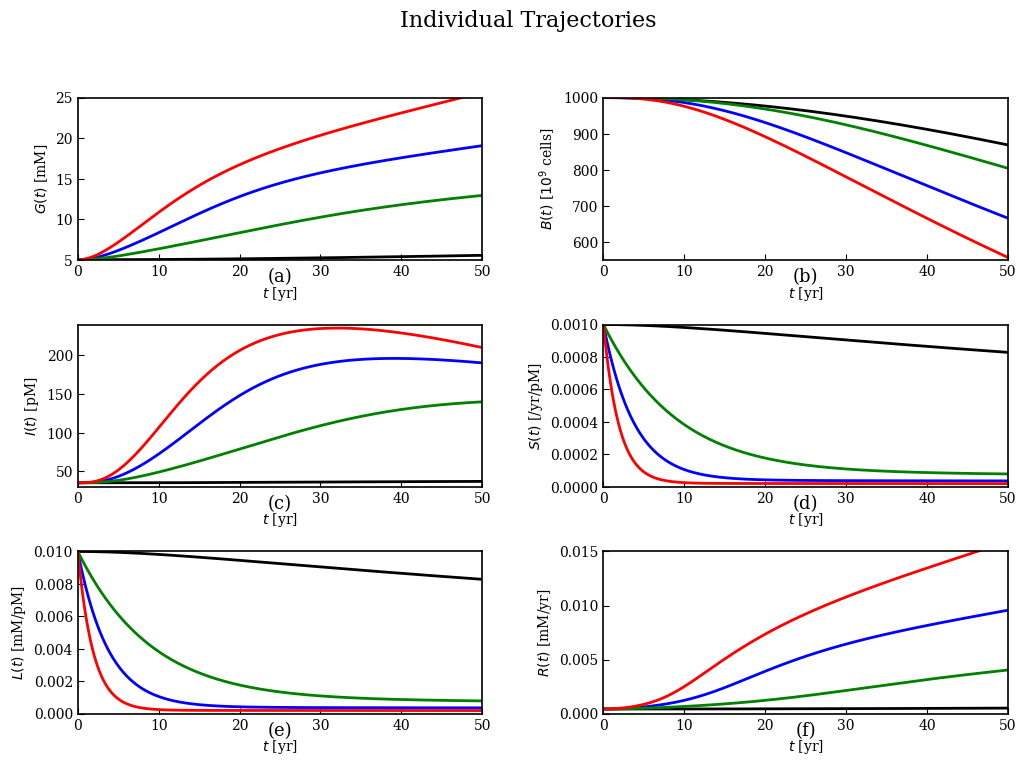

{'t0': 0, 'tend': 50, 't_delta': 0.1, 'G0_N': 5.0, 'B_0': 1000.0, 'I0_N': 35.0, 'S0_N': 0.001, 'L0_N': 0.01, 'R0': 0.000422144, 'k_max_G': 1.00948, 'G_0': 5.0, 'lambda_BA': 0.005, 'k_OB_G': 0.001, 'k_B': 5.0, 'B0_N': 1000.0, 'k_OI': 0.5, 'gamma_IG': 2.0, 'G_I50': 20.0, 'k_max_I': 297.5, 'I_0': 35.0, 'k_S': 1e-05, 'k_SY': 1e-09, 'k_OS': 0.01, 'k_OSF': 0.001, 'k_OSA': 0.0005, 'S_0': 0.001, 'k_L': 0.0001, 'k_LY': 2e-09, 'k_OL': 0.01, 'k_OLF': 0.001, 'k_OLA': 0.0005, 'L_0': 0.01, 's_GR': 0.001, 'rho_GR': 0.5, 'G_R': 10.0, 'R0_N': 0.000422144, 'F': 500.0, 'Y': 0.0, 'A0': 18.0}


In [ ]:
#Black represents normal very healthy situation
#Green represents  gradual decay  of both central and peripheral insulin sensitivites
#Blue represents  more decay  of both central and peripheral insulin sensitivites
#Red represents  more and more rapid decay  of both central and peripheral insulin sensitivites

# Plot Styling
mpl.rcParams.update({
    "text.usetex": False,    # LaTeX for all text
    "font.family": "serif",  # Serif font for paper style
    "axes.linewidth": 1.2,   # Thicker border lines
    "xtick.direction": "in", # Inward ticks
    "ytick.direction": "in",
    "xtick.major.size": 4,
    "ytick.major.size": 4,
    "legend.frameon": False,  # No legend border
    "axes.facecolor": "white", # Clean white background
})

# R computation
def compute_R(G, params):
    discriminant = (4 * params['rho_GR'] * G) + ((G - params['G_R'] - params['rho_GR'])**2)
    R = (params['s_GR'] / 2) * (jnp.sqrt(discriminant) + (G - params['G_R'] - params['rho_GR']))
    return R

# Time span
t_span = jnp.linspace(0, 50, 1000)
age = t_span

# Figure and colors
fig3, ax = plt.subplots(3, 2, figsize=(12, 8))
colors = {'Black': 'black', 'Blue': 'blue', 'Green': 'green', 'Red': 'red'}

# Main plotting loop
for case, color in colors.items():# Loops over each case (Black, Blue, etc.) and its color.
    params = params_cases[case]
    y0 = y0_base.at[0].set(params['G_0']).at[2].set(params['I_0']).at[3].set(params['S_0']).at[4].set(params['L_0'])
    sol = solve_ode(params, t_span, y0) # Runs the simulation from solve ode function to get predictions for all variables over 50 years.

    # Extract and plot trajectories
    ax[0,0].plot(age, sol[:,0], color=color, linewidth=2.0)  # G(t)
    ax[0,1].plot(age, sol[:,1], color=color, linewidth=2.0)  # B(t)
    ax[1,0].plot(age, sol[:,2], color=color, linewidth=2.0)  # I(t)
    ax[1,1].plot(age, sol[:,3], color=color, linewidth=2.0)  # S(t)
    ax[2,0].plot(age, sol[:,4], color=color, linewidth=2.0)  # L(t)

    # Compute R from G
    R_values = compute_R(sol[:,0], params)
    ax[2,1].plot(age, R_values, color=color, linewidth=2.0)  # R(t)

# Axis labels and limits
ax[0,0].set_ylabel(r"$G(t)$ [mM]")
ax[0,0].set_xlabel(r"$t$ [yr]")
ax[0,0].set_xlim(0, 50)
ax[0,0].set_ylim(5, 25)

ax[0,1].set_ylabel(r"$B(t)$ [$10^9$ cells]")
ax[0,1].set_xlabel(r"$t$ [yr]")
ax[0,1].set_xlim(0, 50)
ax[0,1].set_ylim(550, 1000)

ax[1,0].set_ylabel(r"$I(t)$ [pM]")
ax[1,0].set_xlabel(r"$t$ [yr]")
ax[1,0].set_xlim(0, 50)
ax[1,0].set_ylim(30, 240)

ax[1,1].set_ylabel(r"$S(t)$ [/yr/pM]")
ax[1,1].set_xlabel(r"$t$ [yr]")
ax[1,1].set_xlim(0, 50)
ax[1,1].set_ylim(0.0000, 0.0010)

ax[2,0].set_ylabel(r"$L(t)$ [mM/pM]")
ax[2,0].set_xlabel(r"$t$ [yr]")
ax[2,0].set_xlim(0, 50)
ax[2,0].set_ylim(0.000, 0.010)

ax[2,1].set_ylabel(r"$R(t)$ [mM/yr]")
ax[2,1].set_xlabel(r"$t$ [yr]")
ax[2,1].set_xlim(0, 50)
ax[2,1].set_ylim(0.000, 0.015)

# Panel labels (a)-(f)
labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']
for i, axes in enumerate(ax.flatten()):
    # position the labels below x-axis area
    axes.text(25, axes.get_ylim()[0] - 0.05*(axes.get_ylim()[1]-axes.get_ylim()[0]),
              labels[i], fontsize=13, ha='center', va='top')
    axes.grid(False)

# Figure title and layout
plt.suptitle(r"Individual Trajectories", fontsize=16, y=0.99)
plt.subplots_adjust(wspace=0.3, hspace=0.4)
plt.savefig("plot2.png", dpi=300, bbox_inches="tight")
plt.show()

# print(sol[:,0].min(), sol[:,0].max())
# print(sol[:,1].min(), sol[:,1].max())
# print(sol[:,2].min(), sol[:,2].max())
# print(sol[:,3].min(), sol[:,3].max())
# print(sol[:,4].min(), sol[:,4].max())
# print(params)
print(params_cases['Red'])
# print(sol[:,0]) # Increasing glucose

## Step 6: Understanding the NHANES Dataset 2003-2004/ 2005-2006

In [ ]:
# Load the dataset
# Load files 2003-2004
demo2_data=pd.read_sas('/content/DEMO_C.xpt')
print(len(demo2_data)) #10122
glu2_data=pd.read_sas('/content/GLU_D.xpt')
print(len(glu2_data)) #3352
# print(demo2_data.head())
# print(glu2_data.head())

df = demo2_data.merge(glu2_data, on='SEQN', how='left')

# compute counts and missingness
n_total = len(demo2_data)
n_with_both = df[['LBDGLUSI','LBDINSI']].dropna().shape[0]
prop_with_both = n_with_both / n_total
print("Total examined:", n_total)
print("With glucose & insulin:", n_with_both, f"({prop_with_both:.3f})")

df['RIDAGEYR'].describe() #Upper limit 85 years
df['RIDAGEYR'].value_counts().sort_index().tail(10)
# Check max and how many equal to the topcode
df['RIDAGEYR'].max(),(df['RIDAGEYR'] >= 85).sum(), (df['RIDAGEYR'] >= 80).sum()

# define bins (example: 10-year bins from 0 to 80)
bins = np.arange(0, 90, 10)  # 0-9,10-19,...
labels = [f"{b}-{b+9}" for b in bins[:-1]]
df['age_bin'] = pd.cut(df['RIDAGEYR'], bins=bins, labels=labels, right=False)
# unweighted counts
counts = df['age_bin'].value_counts().sort_index()

# weighted counts (use WTMEC2YR; if NaN, fall back to WTINT2YR or 1)
df['wt'] = df['WTMEC2YR'].fillna(1.)
weighted = df.groupby('age_bin',observed=False)['wt'].sum()

print(counts)
print(weighted)

10122
3352
Total examined: 10122
With glucose & insulin: 0 (0.000)
age_bin
0-9      2431
10-19    2650
20-29     910
30-39     832
40-49     789
50-59     609
60-69     773
70-79     611
Name: count, dtype: int64
age_bin
0-9      3.983562e+07
10-19    4.110247e+07
20-29    3.865017e+07
30-39    4.108036e+07
40-49    4.452838e+07
50-59    3.451223e+07
60-69    2.169547e+07
70-79    1.611626e+07
Name: wt, dtype: float64


In [ ]:
## PHYSCIAL ACTIVITY DATASET MAY BE CONSIDERED LATER

Physical_act=pd.read_sas('/content/PAQ_C.xpt')
print(len(Physical_act))
data=Physical_act.to_csv('/content/data.csv',index=False)

9278


In [ ]:
# Load the dataset
# Load files 2005-2006
demo3_data=pd.read_sas('/content/DEMO_D.xpt')
print(len(demo3_data)) #10122
glu3_data=pd.read_sas('/content/L10AM_C.xpt')
print(len(glu3_data)) #3352
# print(demo3_data.head())
# print(glu3_data.head())

df1 = demo3_data.merge(glu3_data, on='SEQN', how='left')

# compute counts and missingness
n_total1 = len(demo3_data)
n_with_both1 = df1[['LBDGLUSI','LBDINSI']].dropna().shape[0]
prop_with_both1 = n_with_both1 / n_total1
#print("Total examined:", n_total1)
#print("With glucose & insulin:", n_with_both1, f"({prop_with_both1:.3f})")

df1['RIDAGEYR'].describe() #Upper limit 85 years
df1['RIDAGEYR'].value_counts().sort_index().tail(10)
# Check max and how many equal to the topcode
df1['RIDAGEYR'].max(),(df1['RIDAGEYR'] >= 85).sum(), (df1['RIDAGEYR'] >= 80).sum()

# define bins (example: 10-year bins from 0 to 80)
bins = np.arange(0, 90, 10)  # 0-9,10-19,...
labels = [f"{b}-{b+9}" for b in bins[:-1]]
df1['age_bin'] = pd.cut(df1['RIDAGEYR'], bins=bins, labels=labels, right=False)
# unweighted counts
counts = df1['age_bin'].value_counts().sort_index()

# weighted counts (use WTMEC2YR; if NaN, fall back to WTINT2YR or 1)
df1['wt'] = df1['WTMEC2YR'].fillna(1.)
weighted = df1.groupby('age_bin', observed=False)['wt'].sum()

#print(counts)
#print(weighted)

10348
3356


# Step 6: Modeling the impact of dietary changes

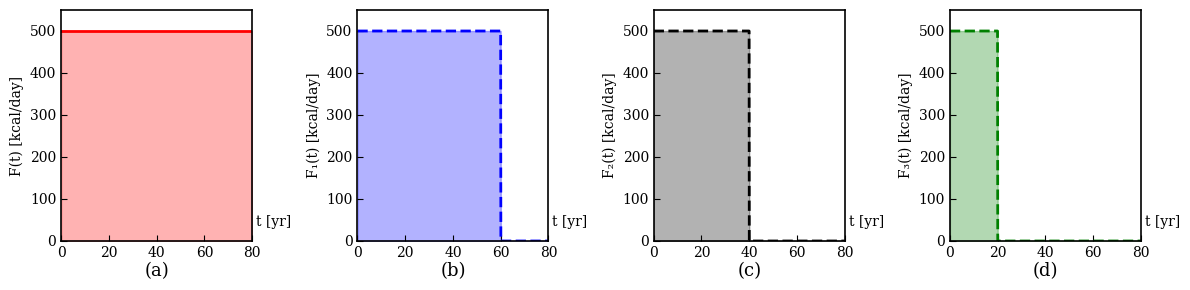

In [ ]:
# Time span: t=0 to 80 years (from age 18)

# Plot Styling
mpl.rcParams.update({
    "text.usetex": False,    # LaTeX for all text
    "font.family": "serif",  # Serif font for paper style
    "axes.linewidth": 1.2,   # Thicker border lines
    "xtick.direction": "in", # Inward ticks
    "ytick.direction": "in",
    "xtick.major.size": 4,
    "ytick.major.size": 4,
    "legend.frameon": False,  # No legend border
    "axes.facecolor": "white", # Clean white background
})

t = jnp.linspace(0, 80, 1000)  # Fine grid for smooth lines

# Define F(t) scenarios (500 kcal/day excess above BMR=0)
F_const = jnp.full_like(t, 500.0)  # Constant 500 for 80 years
F1 = jnp.where(t < 60, 500.0, 0.0)  # Drop at t=60 (age 78)
F2 = jnp.where(t < 40, 500.0, 0.0)  # Drop at t=40 (age 58)
F3 = jnp.where(t < 20, 500.0, 0.0)  # Drop at t=20 (age 38)

# Plot: 1x4 subplots
fig, axs = plt.subplots(1, 4, figsize=(12, 3))  # Wide, compact layout
panels = [F_const, F1, F2, F3]
labels1 = ['(a)', '(b)', '(c)', '(d)']
labels2 = ['F(t)', 'F₁(t)', 'F₂(t)', 'F₃(t)']
colors = ['red', 'blue', 'black', 'green']
styles = ['-', '--', '--', '--']  # Solid for constant, dashed for steps

for i, (F_func, label1, label2, color, style) in enumerate(zip(panels, labels1, labels2, colors, styles)):
    axs[i].fill_between(t, 0, F_func, alpha=0.3, color=color)  # Shaded fill for excess period
    axs[i].plot(t, F_func, color=color, linestyle=style, linewidth=2)
    axs[i].set_xlim(0, 80)
    axs[i].set_ylim(0, 550)
    axs[i].set_ylabel(label2 + ' [kcal/day]')
    axs[i].grid(False)

    # Panel label (a), (b), etc. — placed below the plot, centered
    axs[i].text(40, -50, label1, fontsize=13, ha='center', va='top')

    # "t [yr]" label — bottom-right of each subplot

    axs[i].text(
        1.02, 0.05, 't [yr]',
        transform=axs[i].transAxes,
        fontsize=10,
        ha='left', va='bottom',
        color='black'
    )

#plt.suptitle(r"Different scenarios for excess food intake (daily kcal above baseline)",fontsize=16, y=0.99)
plt.subplots_adjust(wspace=0.3, hspace=0.4)
plt.tight_layout()
plt.savefig("plot3.png", dpi=300, bbox_inches="tight")
plt.show()

# Step 7: Simulations of the impact of dietary changes based of F0,F1,F2,F3 above

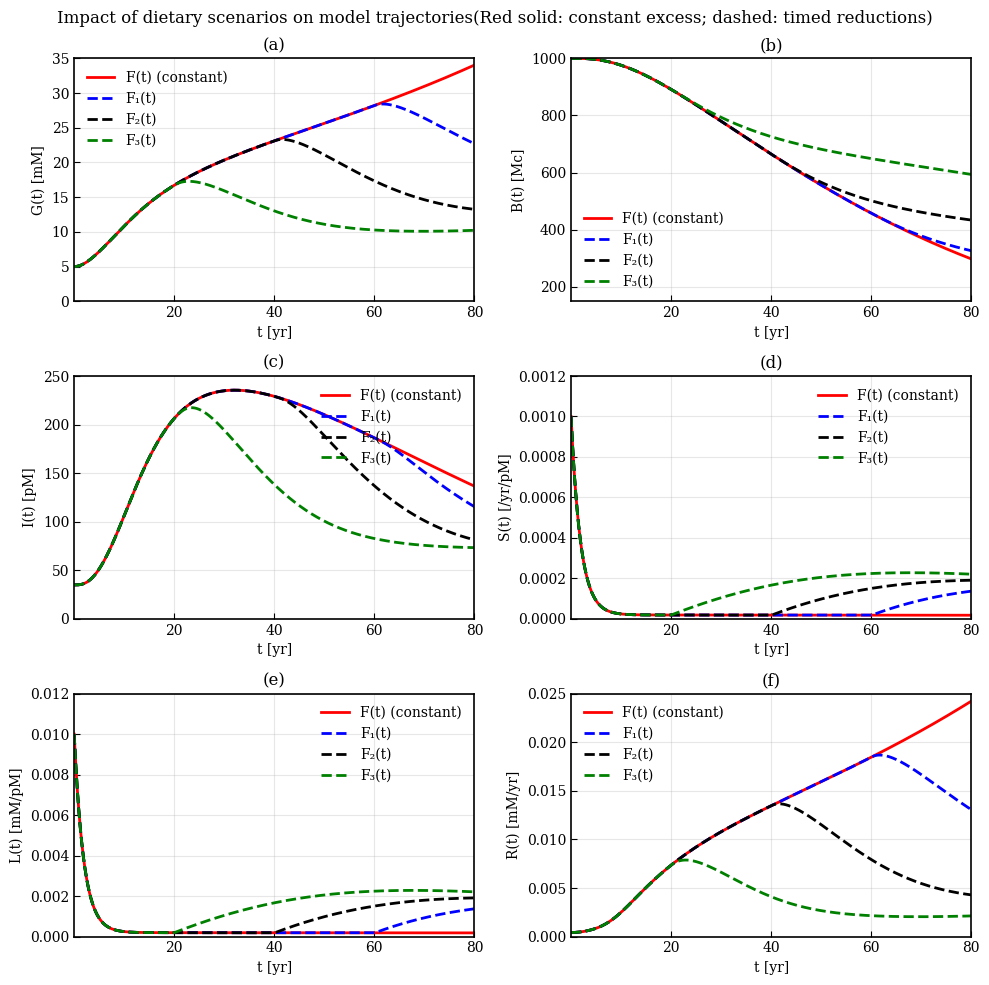

Red: Late-life avg G = 32.77 mM
F1: Late-life avg G = 24.14 mM
F2: Late-life avg G = 13.69 mM
F3: Late-life avg G = 10.15 mM


In [ ]:
# Plot Styling
mpl.rcParams.update({
    "text.usetex": False,    # LaTeX for all text
    "font.family": "serif",  # Serif font for paper style
    "axes.linewidth": 1.2,   # Thicker border lines
    "xtick.direction": "in", # Inward ticks
    "ytick.direction": "in",
    "xtick.major.size": 4,
    "ytick.major.size": 4,
    "legend.frameon": False,  # No legend border
    "axes.facecolor": "white", # Clean white background
})

# Extend to t=80 yr (finer grid for smooth curves)
t_span = jnp.linspace(0, 80, 2000)
A0 = 18.0  # Starting age

# Update "Red" params to include A0
params_red = params_cases['Red'].copy()
params_red['A0'] = A0
params_red['F'] = 500.0  # Excess level

# Initial conditions for Red case
y0_red = jnp.array([
    params_red['G_0'],    # G0
    params_red['B_0'],    # B0
    params_red['I_0'],    # I0
    params_red['S_0'],    # S0
    params_red['L_0'],    # L0
    A0                    # A0
])

# Scenarios dict: F_type as int (0=constant/inf, 1=60yr, 2=40yr, 3=20yr drop)
scenarios = {
    'Red': {'params': params_red, 'F_type': 0, 'color': 'red', 'style': '-', 'label': 'F(t) (constant)'},
    'F1': {'params': params_red, 'F_type': 1, 'color': 'blue', 'style': '--', 'label': 'F₁(t)'},
    'F2': {'params': params_red, 'F_type': 2, 'color': 'black', 'style': '--', 'label': 'F₂(t)'},
    'F3': {'params': params_red, 'F_type': 3, 'color': 'green', 'style': '--', 'label': 'F₃(t)'}
}

# Updated ODE RHS: Inline thresh computation with JAX conditionals
def ode_rhs_timevar(t, y, args):
    params = args['params']
    F_type = args['F_type']
    G, B, I, S, L, A = y

    # Time-varying F: Chain jnp.where for branches
    # F_type 0: always 500 (thresh=inf)
    # F_type 1: 500 if t<60 else 0
    # F_type 2: 500 if t<40 else 0
    # F_type 3: 500 if t<20 else 0
    F = jnp.where(F_type == 0, params['F'],  # Constant
                  jnp.where(F_type == 1, jnp.where(t < 60.0, params['F'], 0.0),
                            jnp.where(F_type == 2, jnp.where(t < 40.0, params['F'], 0.0),
                                      jnp.where(F_type == 3, jnp.where(t < 20.0, params['F'], 0.0), 0.0))))  # Fallback 0
    Y = params['Y']  # Still 0

    # Renal R(G(t)) from Eq. 8
    discriminant = 4 * params['rho_GR'] * G + (G - params['G_R'] - params['rho_GR'])**2
    R = (params['s_GR'] / 2) * (jnp.sqrt(jnp.maximum(discriminant, 0.0)) + (G - params['G_R'] - params['rho_GR']))

    # Eq. 1: Glucose
    dGdt = params['k_max_G'] * jnp.exp(-L * I * G) - S * I * G - R

    # Eq. 2: Beta-cell mass
    dBdt = params['k_B'] * jnp.exp(-params['lambda_BA'] * (A - params['A0'])) - params['k_OB_G'] * G * B

    # Eq. 3: Insulin (Hill)
    hill = G**params['gamma_IG'] / (params['G_I50']**params['gamma_IG'] + G**params['gamma_IG'])
    dIdt = -params['k_OI'] * I + (B / params['B0_N']) * params['k_max_I'] * hill

    # Eq. 4: Peripheral sensitivity S
    dSdt = params['k_S'] - params['k_OS'] * S + params['k_SY'] * Y - params['k_OSF'] * F * S - params['k_OSA'] * (A - params['A0']) * S

    # Eq. 5: Central sensitivity L
    dLdt = params['k_L'] - params['k_OL'] * L + params['k_LY'] * Y - params['k_OLF'] * F * L - params['k_OLA'] * (A - params['A0']) * L

    # Eq. 6: Age
    dAdt = 1.0

    return jnp.array([dGdt, dBdt, dIdt, dSdt, dLdt, dAdt])

# Solve
def solve_ode_timevar(args, t_span, y0):
    # Direct lambda: Passes full args to ode_rhs_timevar
    vector_field = lambda t, y, _: ode_rhs_timevar(t, y, args)

    term = diffrax.ODETerm(vector_field)
    solver = diffrax.Euler()
    sol = diffrax.diffeqsolve(
        term, solver,
        t0=t_span[0], t1=t_span[-1],
        dt0=0.1, y0=y0,
        saveat=diffrax.SaveAt(ts=t_span)
    )
    return sol.ys  # Shape: (n_times, 6)

# Simulate all scenarios
solutions = {}
for name, info in scenarios.items():
    args = {'params': info['params'], 'F_type': info['F_type']}
    sol = solve_ode_timevar(args, t_span, y0_red)
    solutions[name] = sol

# Plot Fig. 5: 3x2 subplots
fig, axs = plt.subplots(3, 2, figsize=(10, 10))
age = t_span # Plot vs. age [yr]

for name, info in scenarios.items():
    sol = solutions[name]
    color, style, label = info['color'], info['style'], info['label']


    # print(f"{name} I min max: {sol[:,2].min()} {sol[:,2].max()}")  # Added to diagnose max I

    axs[0,0].plot(age, sol[:,0], color=color, linestyle=style, linewidth=2, label=label)

    axs[0,1].plot(age, sol[:,1], color=color, linestyle=style, linewidth=2, label=label)

    axs[1,0].plot(age, sol[:,2], color=color, linestyle=style, linewidth=2, label=label)

    axs[1,1].plot(age, sol[:,3], color=color, linestyle=style, linewidth=2, label=label)

    axs[2,0].plot(age, sol[:,4], color=color, linestyle=style, linewidth=2, label=label)

    R_vals = vmap(lambda g: compute_R(g, info['params']))(sol[:,0])
    axs[2,1].plot(age, R_vals, color=color, linestyle=style, linewidth=2, label=label)

# Formatting
axs[0,0].set_title('(a)')
axs[0,0].set_ylabel(r"G(t) [mM]")
axs[0,0].set_xlim(0, 80)
axs[0,0].set_ylim(0, 35)
axs[0,0].legend()

axs[0,1].set_title('(b)')
axs[0,1].set_ylabel(r"B(t) [Mc]")
axs[0,1].set_xlim(0, 80)
axs[0,1].set_ylim(150, 1000)
axs[0,1].legend()

axs[1,0].set_title('(c)')
axs[1,0].set_ylabel(r"I(t) [pM]")
axs[1,0].set_xlim(0, 80)
axs[1,0].set_ylim(0, 250)
axs[1,0].legend(loc='upper right')

axs[1,1].set_title('(d)')
axs[1,1].set_ylabel(r"S(t) [/yr/pM]")
axs[1,1].set_xlim(0, 80)
axs[1,1].set_ylim(0, 0.0012)
axs[1,1].legend()

axs[2,0].set_title('(e)')
axs[2,0].set_ylabel(r"L(t) [mM/pM]")
axs[2,0].set_xlim(0, 80)
axs[2,0].set_ylim(0, 0.012)
axs[2,0].legend()

axs[2,1].set_title('(f)')
axs[2,1].set_ylabel(r"R(t) [mM/yr]")
axs[2,1].set_xlim(0, 80)
axs[2,1].set_ylim(0, 0.025)
axs[2,1].legend()

for ax in axs.flat:
    ax.set_xlabel('t [yr]')
    ax.grid(True, alpha=0.3)
    ax.set_xticks([20, 40, 60, 80])  # Only show these tick marks

plt.suptitle("Impact of dietary scenarios on model trajectories(Red solid: constant excess; dashed: timed reductions)")
plt.tight_layout()
plt.savefig("plot4.png", dpi=300, bbox_inches="tight")
plt.show()

# Print late-life averages
for name in scenarios:
    late_G = jnp.mean(solutions[name][-200:, 0])  # Avg G over last ~2 yr
    print(f"{name}: Late-life avg G = {late_G:.2f} mM")


# Discussion
# G(t): Constant Red rises fastest to ~30 mM by age 60, stabilizes high; F1 (drop age 78) peaks to(~30 mM) and drops to (~27 mM) ; F2 (age 58) peaks lower (~25 mM), declines post-drop; F3 (age 38) peaks ~18 mM, recovers to ~10 mM.
# B(t): Constant decays to ~280 Mc; earlier drops (F3) preserve ~600 Mc by end.
# I(t): All hyperinsulinemic early drops to 75-125
# S(t)/L(t): Steep early drops with F; post-drop plateaus/recoveries stronger for F3 (S~0.0003, L~0.003 end).
#R(t): Spikes with G>10 mM; constant ~0.000 mM/yr late; F3 minimal ~0.0025.
# Printed averages: Red 32.75 mmol/L (severe); F1 24.04 mM; F2 13.65 mM; F3 10.14 mM (Still high). 1 mmol/L = 18 mg/dL 180 mg/dL TIR: 70-180 mg/dL


# Step 8: Fitting survey data and model verification

In [ ]:
# Load NHANES Data for Both Cycles
def load_nhanes_data(demo_path, glu_path, year):
    # Load files
    demo=pd.read_sas(demo_path)
    glu=pd.read_sas(glu_path)

    # Merge
    merged= pd.merge(demo, glu, on='SEQN', how='inner')

    # Handle missing data: Drop rows without key vars
    merged= merged.dropna(subset=['RIDAGEYR', 'LBDGLUSI', 'LBDINSI'])
    merged['G_mM'] = merged['LBDGLUSI']  # mmol/L
    merged['I_pM'] = merged['LBDINSI']  # Pmol/L

    # Clip age to 80
    merged['RIDAGEYR'] = merged['RIDAGEYR'].clip(upper=80)

    # Young sample (18-22, n=100 or all if fewer)
    young = merged[(merged['RIDAGEYR'] >= 18) & (merged['RIDAGEYR'] <= 22)]
    if len(young) < 100:
        print(f"{year}: Only {len(young)} young—using all")
        young_sample = young
    else:
        young_sample = young.sample(100, random_state=42)
    initials = young_sample[['RIDAGEYR', 'G_mM', 'I_pM']].values  # A0, G0, I0

    # Full binned data for real avgs/SD (ages 20-80)
    full = merged[(merged['RIDAGEYR'] >= 20) & (merged['RIDAGEYR'] <= 80)].copy()
    bins = [10,20, 30, 40, 50, 60, 70,80]
    age_mid = np.array([15,25, 35, 45, 55, 65, 75])  # Midpoints for x-axis (years)
    full['age_bin'] = pd.cut(full['RIDAGEYR'], bins=bins, labels=age_mid)
    binned = full.groupby('age_bin', observed=False)[['G_mM', 'I_pM']].agg(['mean', 'std', 'count']).dropna()


    data_G_mean = binned['G_mM']['mean'].values
    data_G_sd = binned['G_mM']['std'].values
    data_I_mean = binned['I_pM']['mean'].values
    data_I_sd = binned['I_pM']['std'].values

    return initials, age_mid, data_G_mean, data_G_sd, data_I_mean, data_I_sd

# Load training (2003-2004)
initials_train, age_mid, G_mean_train, G_sd_train, I_mean_train, I_sd_train = load_nhanes_data(
    '/content/DEMO_C.xpt', '/content/L10AM_C.xpt', '2003-2004'
)

# Load validation (2005-2006)
initials_val, age_mid, G_mean_val, G_sd_val, I_mean_val, I_sd_val = load_nhanes_data(
    '/content/DEMO_D.xpt', '/content/GLU_D.xpt', '2005-2006'
)

print("Training initials shape:", initials_train.shape)  # (n,3)
#print(initials_train)
print("Validation G means:", G_mean_val)
print(G_mean_train)
print(G_sd_train)
print(I_mean_train)
print(I_sd_train)
print(G_mean_val)
print(G_sd_val)
print(I_mean_val)
print(I_sd_val)
print(age_mid)

Training initials shape: (100, 3)
Validation G means: [5.10386842 5.08388989 5.48455556 5.77480217 6.37145421 6.69685762
 6.12889728]
[4.96832    5.00190251 5.28822284 5.68001548 6.3743     6.59825439
 6.19753398]
[0.55556338 0.58942894 1.18336951 1.70731872 2.94674252 2.72683387
 1.82131802]
[92.5176     64.68350975 76.59793872 62.84266254 72.75042857 80.81824561
 63.40587379]
[116.74062487  66.86001995 114.4454213   52.84376538  78.43837787
  88.16432325  75.73686454]
[5.10386842 5.08388989 5.48455556 5.77480217 6.37145421 6.69685762
 6.12889728]
[0.45581309 0.88022482 1.68483157 1.67289076 2.54523216 2.50653739
 1.39537681]
[76.63736842 77.92948315 69.15285714 74.24536585 71.78131868 80.85298013
 65.38984894]
[ 73.94283726  80.85272218  61.37345163  67.09452855  78.94709072
 127.05547526  69.23461272]
[15 25 35 45 55 65 75]


In [ ]:
theta_bounds = [
    (0, 10*0.005),   # lambda_BA *** Why
    (0, 0.005),   # k_OB_G
    (0, 1.0),    # k_OI
    (0, 1e-3),   # k_OSF
    (0, 2E-3),   # k_OSA
    (0, 1e-3),   # k_OLF
    (0, 50*0.0007)    # k_OLA *** why
]
np_limits = np.array(theta_bounds)
x0 = np_limits[:,0]+(np_limits[:,1]-np_limits[:,0])/2
print(x0)
print(theta_bounds)

[0.025  0.0025 0.5    0.0005 0.001  0.0005 0.0175]
[(0, 0.05), (0, 0.005), (0, 1.0), (0, 0.001), (0, 0.002), (0, 0.001), (0, 0.034999999999999996)]


## Step 9: Parameter Optimization Process

In [ ]:
# A parameter optimization process using local gradient-based optimization L-BFGS-B to fit a model to training data.
# Fit θ on Training Data (2003-2004)


# The model parameters

theta_keys = ['lambda_BA', 'k_OB_G', 'k_OI', 'k_OSF', 'k_OSA', 'k_OLF', 'k_OLA'] #Selected for fine tuning remaining parameters kept fixed
# theta_bounds = [
#     (0, 1.0),   # lambda_BA
#     (0, 1.0),   # k_OB_G
#     (0, 1.0),    # k_OI
#     (0, 1.0),   # k_OSF
#     (0, 1.0),   # k_OSA
#     (0, 1.0),   # k_OLF
#     (0, 1.0)    # k_OLA
# ]

# Fixed params
fixed_params = params_base.copy() # Creates a copy of params_base dictionary
fixed_params['F'] = 0.0 # Not optimized held constant
fixed_params['Y'] = 0.0 # Not optimized held constant

# t_eval: Years after start (age_mid - 10)
t_span = jnp.linspace(0, 60, 100)  # 60 yr
t_eval = age_mid - 10.0 # Age_mid is [15,25 35 45 55 65 75]



# The Objective (Error) function

def error_func(theta_flat, initials, fixed_params, t_eval, data_G, data_I, w_G=1.0/6.0, w_I=1.0/80.0): # normalized weights ~6 and ~80
    theta = dict(zip(theta_keys, theta_flat))
    params = {**fixed_params, **theta}

    sim_G, sim_I = [], []

    start = time.time()
    for person in initials:  # n=100
        A0, G0, I0 = person #Input parameters considered
        y0 = jnp.array([G0, fixed_params['B_0'], I0, fixed_params['S_0'], fixed_params['L_0'], A0])
        sol = solve_ode(params, t_span, y0)
        # Interp at t_eval (yr after start)
        interp_G = np.interp(t_eval, t_span, sol[:,0]) #extract the simulated values for G
        interp_I = np.interp(t_eval, t_span, sol[:,2]) #extract the simulated values for I
        sim_G.append(interp_G) # Appends interpolated values to sim_G
        sim_I.append(interp_I) # Appends interpolated values to sim_I

    sim_G_avg = np.mean(sim_G, axis=0) # Computes the average simulated G
    sim_I_avg = np.mean(sim_I, axis=0) # Computes the average simulated I

    end = time.time()
    # print(end-start)

    E = w_G * np.sqrt(np.mean((data_G - sim_G_avg)**2)) + w_I * np.sqrt(np.mean((data_I - sim_I_avg)**2))
    return E #Compute root mean square error


# Run DE
#result = differential_evolution(
    #lambda theta: error_func(theta, initials_train, fixed_params, t_eval, G_mean_train, I_mean_train),
    #bounds=theta_bounds, maxiter=200, popsize=15, workers=1, disp=True
#)

# Run the optimization

result = scipy.optimize.minimize(
    lambda theta: error_func(theta, initials_train, fixed_params, t_eval, G_mean_train, I_mean_train),
    x0=x0,bounds=theta_bounds
)

best_theta = result.x
print(result.message)
print(result.nit)
print((best_theta-np_limits[:,0])/((np_limits[:,1]-np_limits[:,0])))
best_E = result.fun
fitted_params = {**fixed_params, **dict(zip(theta_keys, best_theta))}
print("Fitted θ:", dict(zip(theta_keys, best_theta)))
print("Best Error:", best_E)
# print(t_span)
# print(best_theta)


CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
30
[0.67157611 0.08429402 0.5        0.5        0.07211725 0.5
 0.26047701]
Fitted θ: {'lambda_BA': np.float64(0.03357880574866013), 'k_OB_G': np.float64(0.0004214701033233186), 'k_OI': np.float64(0.5), 'k_OSF': np.float64(0.0005), 'k_OSA': np.float64(0.00014423449978881396), 'k_OLF': np.float64(0.0005), 'k_OLA': np.float64(0.009116695465725334)}
Best Error: 0.3476717846477537


## STEP 10: SIMULATED PROGRESSION OF GLUCOSE AND INSULIN OVER 720 MONTHS

In [ ]:
## POPULATION SIMULATOR
# OBSERVED DATA POINTS IN MONTHS
# x0 = np_limits[:,0]+(np_limits[:,1]-np_limits[:,0])/2
# best_theta = x0
# print(best_theta[4])
#best_theta[5] = 1E-3
fitted_params = {**fixed_params, **dict(zip(theta_keys, best_theta))}
age_mid = jnp.array([15, 25, 35, 45, 55, 65, 75])  # 7 bins
baseline_age = age_mid[0]
t_obs_train = (age_mid - baseline_age) * 12
t_obs_val   = (age_mid - baseline_age) * 12

#print("t_obs_train (months):", t_obs_train)
#print("t_obs_train (months):", t_obs_val)


@jit
def make_y0s(initials, params):
    # initials shape (N, 3) as [A0, G0, I0]
    def triple_to_y0(triple):
        A0, G0, I0 = triple
        return jnp.array([G0, params['B_0'], I0, params['S_0'], params['L_0'], A0])
    return jax.vmap(triple_to_y0)(initials)

def simulate_population_full_vmap(initials, params, n_pts=1200):
    mean_age = initials[:, 0].mean()
    t_years = jnp.linspace(baseline_age, baseline_age + 60, n_pts)  # 60 years forward
    y0s = make_y0s(initials, params)
    def integrate(y0):
        sol = solve_ode(params, t_years, y0)
        return sol[:,0], sol[:,2]             # G, I
    G_all, I_all = jax.vmap(integrate)(y0s)
    return t_years, G_all, I_all,G_all.mean(0), G_all.std(0), I_all.mean(0), I_all.std(0)

# 2003-2004 (training)
(t_years_train,
 G_all_train, I_all_train,
 G_mean_train_sim, G_sd_train_sim,
 I_mean_train_sim, I_sd_train_sim) = simulate_population_full_vmap(initials_train, fitted_params)

# 2005-2006 (validation)
(t_years_val,
 G_all_val, I_all_val,
 G_mean_val_sim, G_sd_val_sim,
 I_mean_val_sim, I_sd_val_sim) = simulate_population_full_vmap(initials_val, fitted_params)

 # TIME IN MONTHS (0-720)
t_months = (t_years_train - t_years_train[0]) * 12


# ---- PLOT ----
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

def draw_panel(ax, t_mo, indiv, mean, sd, data_t, data_mean, data_sd,
               color, ylabel, ylim):
    for traj in indiv:
        ax.plot(t_mo, traj, color=color, lw=0.8, alpha=0.15)
    ax.plot(t_mo, mean, color=color, lw=2.8, label='Mean (sim)')
    ax.fill_between(t_mo, mean - 2*sd, mean + 2*sd, color=color, alpha=0.25)
    ax.errorbar(data_t, data_mean, yerr=data_sd,
                fmt='ko', capsize=5, label='NHANES', markersize=7, capthick=1.5)
    ax.set_xlabel('Time (mo)')
    ax.set_ylabel(ylabel)
    ax.set_xlim(-30, 740)
    ax.set_ylim(*ylim)
    ax.legend()

# TOP ROW
draw_panel(axs[0,0], t_months, G_all_train, G_mean_train_sim, G_sd_train_sim,
           t_obs_train, G_mean_train, G_sd_train,
           'red', 'Glucose level (mM)', (0, 14))

draw_panel(axs[0,1], t_months, I_all_train, I_mean_train_sim, I_sd_train_sim,
           t_obs_train, I_mean_train, I_sd_train,
           'blue', 'Insulin level (pM)', (0, 500))

# BOTTOM ROW
draw_panel(axs[1,0], t_months, G_all_val, G_mean_val_sim, G_sd_val_sim,
           t_obs_val, G_mean_val, G_sd_val,
           'red', 'Glucose level (mM)', (0, 14))

draw_panel(axs[1,1], t_months, I_all_val, I_mean_val_sim, I_sd_val_sim,
           t_obs_val, I_mean_val, I_sd_val,
           'blue', 'Insulin level (pM)', (0, 500))

# Titles
axs[0,0].set_title('Glucose level (mM)')
axs[0,1].set_title('Insulin level (pM)')
axs[1,0].set_title('Glucose level (mM)')
axs[1,1].set_title('Insulin level (pM)')

plt.suptitle("Simulated progression of glucose and insulin levels over 720 months", fontsize=13, y=0.98)
plt.tight_layout()
plt.savefig('yv.png')
plt.show()

print(t_years_train[:5], t_years_train[-5:])
print(G_all_train[0, :5], G_all_train[0, -5:])
## CHECKS
# print("t_years:", t_years_train.shape, "→ should be (1200,)")
# print("G_all:", G_all_train.shape, "→ should be (N_individuals, 1200)")
#print("I_all:", I_all_train.shape, "→ should be (N_individuals, 1200)")
#print("G_mean:", G_mean_train_sim.shape, "→ should be (1200,)")
#print("G_std:", G_sd_train_sim.shape, "→ should be (1200,)")
#print("I_mean:", I_mean_train_sim.shape, "→ should be (1200,)")
#print("I_std:", I_sd_train_sim.shape, "→ should be (1200,)")
#print("t_years:", t_years_val.shape, "→ should be (1200,)")
#print("G_all:", G_all_val.shape, "→ should be (N_individuals, 1200)")
#print("I_all:", I_all_val.shape, "→ should be (N_individuals, 1200)")
#print("G_mean:", G_mean_val_sim.shape, "→ should be (1200,)")
#print("G_std:", G_sd_val_sim.shape, "→ should be (1200,)")
#print("I_mean:", I_mean_val_sim.shape, "→ should be (1200,)")
#print("I_std:", I_sd_val_sim.shape, "→ should be (1200,)")
#print("t_years[0:5] =", t_years_train[:5])
#print("G_all[0,:10] =", G_all_train[0,:10])
#print("I_all[0,:5] =", I_all_train[0,:5])
#print("G_mean[0], G_mean[-1] =", G_mean_train[0], G_mean_train[-1])
#print("I_mean[0], I_mean[-1] =", I_mean_train[0], I_mean_train[-1])
#test_initials = jnp.array([[25.0, 5.0, 100.0],[30.0, 5.5, 120.0]])
#y0s = make_y0s(test_initials, fitted_params)
#print("y0s shape:", y0s.shape)
#print("y0s example:\n", y0s)
#print("t_obs_train:", t_obs_train.shape)
#print("G_mean_train:", np.shape(G_mean_train))
#print("G_sd_train:", np.shape(G_sd_train))
#print(age_mid)
#print(initials_train[:,0].mean())
#print(G_all_train[0, 0])
#print(t_obs_train)
#print(G_mean_val)
#print("G0 values (should be ~4.97):", initials_train[:, 1])
#print("Simulated G: start =", G_mean_train_sim[0], "end =", G_mean_train_sim[-1])
#print("NHANES G:     start =", G_mean_train[0],  "end =", G_mean_train[-1])
#print(G_mean_train_sim[0], "→", G_mean_train_sim[-1])
#print(fitted_params)
#print(sol[:,0])
#print(sol[:,2])
#print(initials_val.shape)
#print(G_all_train.shape)
np.savetxt("/content/G_all_train_sim.csv", G_all_train, delimiter=",", fmt="%.6f")
#print("Initial G0 values:", initials_train[:,1])
#print("Initial I0 values:", initials_train[:,2])
#print("Initial G_mean:", G_all_train[:,0].mean())
#print("Final G_mean:", G_all_train[:,-1].mean())
#print("Params used:", fitted_params)
#print("Example G trajectory:", G_all_train[0,:20])
#print(G_mean_train)
#print(I_mean_train)
#print(G_mean_val)
#print(I_mean_val)
#print(G_mean_train_sim.shape)


##DESCRIPTION

#(equivalent to 60 years) based on data obtained from NHANES 2003–2004 survey "
#"(upper figure) and data obtained from NHANES 2005–2006 survey (lower figure). "
#"Pale curves depict simulated data for individual patients, bold curves represent "
#"average simulated values for the entire virtual sample. The actual NHANES survey "
#"data is displayed in black and expressed as the mean value with standard deviation bars."


In [ ]:
# type II maximum likelihood estimation
# So the simulated parameters would come from distributions and we would aim to optimize the parameters of the distributions and not the simulated parameters themselves
# The simulated parameters would emerge by taking samples from the defined distributions

## Step 11: The Probablistic Model

In [ ]:
# ---- Imports ----
import jax
import jax.numpy as jnp
import numpy as np
from functools import partial
from scipy.optimize import minimize
from jax.scipy.special import logsumexp
import time

# ---- Assume these exist from your code ----
# solve_ode(params, t_span, y0) -> returns array shape (len(t_span), n_vars)
# theta_keys = [...]
# fixed_params = {...}
# initials_train = list/array of (A0,G0,I0) for n persons
# t_span = jnp.linspace(...)
# t_eval = scalar or array(s) where you compare outputs
# G_mean_train, I_mean_train: observed aggregate values (matching your previous set-up)

# ---- Helper: simulate for a single theta sample ----
@partial(jax.jit, static_argnums=(6,))
def simulate_for_theta(theta_sample, initials, fixed_params, t_span, t_eval, theta_keys, solve_ode):
    """
    theta_sample: array shape (n_theta,) in parameter space (positive values)
    returns: sim_G_avg, sim_I_avg (scalars or arrays matching data shape)
    """
    params = {**fixed_params, **dict(zip(theta_keys, theta_sample))}
    # For each person initial, run ODE
    def per_person_sim(person):
        A0, G0, I0 = person
        # adjust y0 as in your code (order: G, B, I, S, L, A)
        y0 = jnp.array([G0, fixed_params['B_0'], I0, fixed_params['S_0'], fixed_params['L_0'], A0])
        sol = solve_ode(params, t_span, y0)   # shape (len(t_span), n_states)
        # interpolate at t_eval: assuming t_eval scalar
        # if t_eval scalar:
        interp_G = jnp.interp(t_eval, t_span, sol[:,0])
        interp_I = jnp.interp(t_eval, t_span, sol[:,2])
        return jnp.array([interp_G, interp_I])
    sims = jax.vmap(per_person_sim)(initials)   # shape (n_persons, 2)
    sim_G_avg = jnp.mean(sims[:,0])
    sim_I_avg = jnp.mean(sims[:,1])
    return sim_G_avg, sim_I_avg

# ---- Log-likelihood of observed aggregate given simulated aggregate ----
def log_gaussian_pdf(data, mean, sigma):
    # data and mean are scalar or same-shape arrays
    var = sigma**2
    return -0.5 * jnp.sum(jnp.log(2*jnp.pi*var) + ((data - mean)**2)/var)

# ---- The Monte-Carlo approx of marginal log-likelihood ----
def approx_marginal_loglik(phi_flat, rng_key, K,
                           initials, fixed_params, t_span, t_eval,
                           theta_keys, G_obs, I_obs,
                           solve_ode,
                           obs_sigma_G=0.01, obs_sigma_I=0.01):
    """
    phi_flat: concatenated [mu (7), log_sigma (7)] -> length 14
    returns: negative log marginal likelihood (we minimize)
    """
    D = len(theta_keys)
    mu = phi_flat[:D]
    log_sigma = phi_flat[D:]
    sigma = jnp.log1p(jnp.exp(log_sigma)) + 1e-6   # softplus -> positive

    # draw K standard normals (shape K x D)
    keys = jax.random.split(rng_key, 1)
    eps = jax.random.normal(keys[0], shape=(K, D))

    # transform to theta samples (log-normal)
    log_theta_samples = mu[None, :] + eps * sigma[None, :]
    theta_samples = jnp.exp(log_theta_samples)  # shape (K, D)

    # simulate for each theta sample -> vectorize
    sim_fn = partial(simulate_for_theta, initials=initials,
                     fixed_params=fixed_params, t_span=t_span, t_eval=t_eval,
                     theta_keys=theta_keys, solve_ode=solve_ode)

    sims = jax.vmap(sim_fn)(theta_samples)   # shape (K, 2)
    sim_G = sims[:,0]
    sim_I = sims[:,1]

    # compute log p(data | sim_k) for each k
    logp_G = -0.5 * (jnp.log(2*jnp.pi*obs_sigma_G**2) + ((G_obs - sim_G)**2)/(obs_sigma_G**2))
    logp_I = -0.5 * (jnp.log(2*jnp.pi*obs_sigma_I**2) + ((I_obs - sim_I)**2)/(obs_sigma_I**2))
    logp_k = logp_G + logp_I   # shape (K,)

    # marginal log-likelihood ≈ log(1/K * sum_k exp(logp_k))
    # = logsumexp(logp_k) - log(K)
    log_marginal = logsumexp(logp_k) - jnp.log(K)
    # negative for minimizer
    return -float(log_marginal)

# ---- Wrap for SciPy minimize (convert JAX random key per call) ----
def make_objective(initial_phi, seed=0, K=256,
                   initials=initials_train, fixed_params=fixed_params,
                   t_span=t_span, t_eval=t_eval, theta_keys=theta_keys,
                   G_obs=G_mean_train, I_obs=I_mean_train,
                   solve_ode=solve_ode, obs_sigma_G=0.02, obs_sigma_I=0.02):
    rng = np.random.RandomState(seed)
    def obj_np(phi_flat_np):
        # draw a fresh rng key per call for stochasticity
        sub_seed = rng.randint(0, 2**31-1)
        rng_key = jax.random.PRNGKey(int(sub_seed))
        val = approx_marginal_loglik(jnp.array(phi_flat_np), rng_key, K,
                                     initials, fixed_params, t_span, t_eval,
                                     theta_keys, G_obs, I_obs,
                                     solve_ode, obs_sigma_G, obs_sigma_I)
        return float(val)
    return obj_np

# ---- Initialization ----
D = len(theta_keys)
# initialize mu near log of previous best theta (if you have x0)
# fallback to log(0.1)
mu0 = jnp.log(jnp.clip(jnp.array(x0), 1e-6, 1e6)) if 'x0' in globals() else jnp.log(jnp.ones(D)*0.1)
log_sigma0 = jnp.log(jnp.ones(D)*0.5)   # initial unconstrained log-sigma
phi0 = jnp.concatenate([mu0, log_sigma0])

# ---- Run SciPy optimization (note: stochastic objective; increase K for stability) ----
obj = make_objective(phi0, seed=42, K=256,
                     initials=initials_train, fixed_params=fixed_params,
                     t_span=t_span, t_eval=t_eval, theta_keys=theta_keys,
                     G_obs=G_mean_train, I_obs=I_mean_train,
                     solve_ode=solve_ode, obs_sigma_G=0.02, obs_sigma_I=0.02)

res = minimize(obj, np.array(phi0), method='L-BFGS-B', options={'maxiter':200})

phi_hat = res.x
mu_hat = phi_hat[:D]
log_sigma_hat = phi_hat[D:]
sigma_hat = np.log1p(np.exp(log_sigma_hat))

print("Optimization success:", res.success, res.message)
print("Estimated mu (log-space):", mu_hat)
print("Estimated sigma:", sigma_hat)
print("Estimated median parameters (exp(mu)):", np.exp(mu_hat))

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch, Rectangle, Circle, ArrowStyle
import matplotlib.patheffects as path_effects

# Create figure with a nice size
fig, ax = plt.subplots(figsize=(18, 12))
ax.set_xlim(0, 18)
ax.set_ylim(0, 12)
ax.axis('off')

# Helper function to add a rounded box
def add_box(x, y, width, height, text, color, title, fontsize=10):
    box = FancyBboxPatch((x, y), width, height, boxstyle="round,pad=0.1", fc=color, ec="black", lw=1.5)
    ax.add_patch(box)
    ax.text(x + width/2, y + height - 0.4, title, ha='center', va='top', fontsize=12, fontweight='bold', color='white')
    ax.text(x + width/2, y + height - 1.2, text, ha='center', va='top', fontsize=fontsize, color='white', wrap=True)

# Title
ax.text(9, 11.7, "Data Pipeline and Preprocessing", ha='center', fontsize=20, fontweight='bold')

# 1. Baseline Physiological Ranges (purple)
add_box(1, 7.5, 4, 3.5,
        "• Plasma glucose levels:\n  70–99 mg/dL (fasting)\n"
        "• Insulin levels:\n  2.6–24.9 µU/mL\n"
        "• Participant age:\n  20–79 years",
        "#6a5acd", "Baseline Physiological Ranges")

# 2. Parameter Values from Longitudinal Model (brown)
add_box(6, 7.5, 4, 3.5,
        "• dS/dt = g(S, I, G, a, t)\n"
        "• dS/dt = f(S, I, G, a, t)\n"
        "• dI/dt = f(S, I, G, a, t)\n"
        "• dI/dt = g(S, I, G, a, t)\n"
        "• dL/dt = g(S, I, G, a, t)\n"
        "(Gaetano et al.)",
        "#d2691e", "Parameter Values from\nLongitudinal Model\n(Gaetano et al.)")

# 3. NHANES Data (blue)
add_box(11, 7.5, 4, 3.5,
        "• Plasma glucose levels\n"
        "• Insulin levels\n"
        "• Participant age\n"
        "NHANES 2003–2004 and\n2005–2006 Cycles",
        "#4682b4", "Data from NHANES\n2003–2004 and\n2005–2006 Cycles")

# 4. Agent-Based Component (orange)
add_box(11, 3, 4, 3.5,
        "• Population demographics\n"
        "• BMI distributions\n"
        "• Age-specific lifestyle factors\n"
        "• Behavioral and dietary statistics\n"
        "• Health surveillance data sources",
        "#cd853f", "Agent-Based Component")

# Bottom preprocessing steps
add_box(1, 1.5, 4, 1.5, "Normalization and\nstandardization", "#00b7eb")
add_box(6, 1.5, 4, 1.5, "Interpolation to match\nmodel time intervals", "#00b7eb")
add_box(11, 1.5, 4, 1.5, "Interpolation to match\ntime intervals", "#00b7eb")
add_box(11, 0, 4, 1, "Grouping by age and other\ndemographic factors", "#00b7eb")

# Icons / symbols
# R logo (simple red R arrow)
ax.text(0.5, 10.5, "R", fontsize=40, color="red", fontweight='bold', path_effects=[path_effects.withStroke(linewidth=4, foreground="white")])

# Graph icon
ax.plot([8.5, 9.5], [9.5, 10.5], color='black', lw=3)
ax.plot([9.5, 9.5], [9.5, 10.5], color='black', lw=3)

# Document icon
ax.add_patch(Rectangle((11.5, 9.8), 1.5, 1.5, fill=True, fc='white', ec='black'))
ax.text(12.25, 10.3, "Data", ha='center', va='center', fontsize=12)

# People icon (simple)
for x in [12.5, 13.5, 14.5]:
    ax.add_patch(Circle((x, 10.5), 0.3, fc='black'))
    ax.plot([x, x], [10.2, 9.8], color='black', lw=3)

# Arrows
arrow_style = ArrowStyle("->", head_length=0.4, head_width=0.2)
ax.annotate("", xy=(5, 9), xytext=(6, 9), arrowprops=dict(arrowstyle=arrow_style, lw=2))
ax.annotate("", xy=(10, 9), xytext=(11, 9), arrowprops=dict(arrowstyle=arrow_style, lw=2))
ax.annotate("", xy=(12.5, 7.5), xytext=(12.5, 6), arrowprops=dict(arrowstyle=arrow_style, lw=2))
ax.annotate("", xy=(3, 7.5), xytext=(3, 4), arrowprops=dict(arrowstyle=arrow_style, lw=2))
ax.annotate("", xy=(9, 7.5), xytext=(9, 4), arrowprops=dict(arrowstyle=arrow_style, lw=2))
ax.annotate("", xy=(13.5, 7.5), xytext=(13.5, 4), arrowprops=dict(arrowstyle=arrow_style, lw=2))
ax.annotate("", xy=(3, 3), xytext=(9, 3), arrowprops=dict(arrowstyle=arrow_style, lw=2, connectionstyle="arc3,rad=0.2"))
ax.annotate("", xy=(9, 3), xytext=(13.5, 3), arrowprops=dict(arrowstyle=arrow_style, lw=2))

# Show the figure
plt.tight_layout()
plt.savefig("data_pipeline_preprocessing.png", dpi=300, bbox_inches='tight')
plt.show()